PPM (92, 112) L


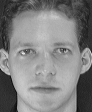

In [1]:
# Loading and displaying an image
from PIL import Image
img = Image.open('/home/dvveera/db/orl/s1/1.pgm')
print(img.format, img.size, img.mode)
display(img)

In [2]:
# Creating training, validation and test datasets
import os
import shutil

def copy_data(dir_s, fname):
    os.chdir(dir_s + '/' + fname)
    dir_train = dir_s + '/train/' + fname
    dir_valid = dir_s + '/valid/' + fname
    dir_test = dir_s + '/test/' + fname
    if not os.path.exists(dir_train):
        os.makedirs(dir_train)
    if not os.path.exists(dir_valid):
        os.makedirs(dir_valid)
    if not os.path.exists(dir_test):
        os.makedirs(dir_test)
    i = 1
    for filename in os.listdir(dir_s + '/' + fname):
        if i <= 6:
            shutil.copy(dir_s + '/' + fname + '/' + str(i) + '.pgm', dir_train)
        elif i <= 8:
            shutil.copy(dir_s + '/' + fname + '/' + str(i) + '.pgm', dir_valid)
        else:
            shutil.copy(dir_s + '/' + fname + '/' + str(i) + '.pgm', dir_test)
        i = i + 1

dir_src = '/home/dvveera/db/orl'
os.chdir(dir_src)
for filename in os.listdir(dir_src):
    if filename.startswith('s'):
        copy_data(dir_src, filename)
print('Separated Training, Validation and Test Data')

Separated Training, Validation and Test Data


In [3]:
# Assign Labels
def assign_addr_label(path):
    dirs = os.listdir(path)
    addrs = []
    labels = []
    for d in dirs:
        os.chdir(path + '/' + d)
        addr = glob.glob(path + '/' + d + '/' + '*')
        label = [d for i in range(len(addr))]
        addrs.extend(addr)
        labels.extend(label)
    return list(zip(addrs, labels))

import glob
train_path = '/home/dvveera/db/orl/train'
train_data = assign_addr_label(train_path)
train_addrs, train_labels = zip(*train_data)
valid_path = '/home/dvveera/db/orl/valid'
valid_data = assign_addr_label(valid_path)
valid_addrs, valid_labels = zip(*valid_data)
test_path = '/home/dvveera/db/orl/test'
test_data = assign_addr_label(test_path)
test_addrs, test_labels = zip(*test_data)
print('Assigned Labels to Training, Validation and Test Data')

Assigned Labels to Training, Validation and Test Data


In [4]:
# Load images and save them
import numpy as np
train_storage = []
valid_storage = []
test_storage = []
mean_storage = []
# Training Images
for i in range(len(train_addrs)):
    if i % 20 == 0 and i > 1:
        print('Train data: {}/{}'.format(i, len(train_addrs)))
    addr = train_addrs[i]
    img = Image.open(addr)
    img = np.array(img)
    train_storage.append(img)
    # print(np.array(img))
    mean_storage.append(np.sum(img) / float(len(train_labels)))
# print(train_storage)
# Validation Images
for i in range(len(valid_addrs)):
    if i % 20 == 0 and i > 1:
        print('Valid data: {}/{}'.format(i, len(valid_addrs)))
    addr = valid_addrs[i]
    img = Image.open(addr)
    img = np.array(img)
    valid_storage.append(img)
    # print(np.array(img))
# print(valid_storage)
# Test Images
for i in range(len(test_addrs)):
    if i % 20 == 0 and i > 1:
        print('Test data: {}/{}'.format(i, len(test_addrs)))
    addr = test_addrs[i]
    img = Image.open(addr)
    img = np.array(img)
    test_storage.append(img)
    # print(np.array(img))
# print(test_storage)

Train data: 20/240
Train data: 40/240
Train data: 60/240
Train data: 80/240
Train data: 100/240
Train data: 120/240
Train data: 140/240
Train data: 160/240
Train data: 180/240
Train data: 200/240
Train data: 220/240
Valid data: 20/80
Valid data: 40/80
Valid data: 60/80
Test data: 20/80
Test data: 40/80
Test data: 60/80


In [5]:
# Combine data and labels
train_set = list(zip(train_storage, train_labels))
valid_set = list(zip(valid_storage, valid_labels))
test_set = list(zip(test_storage, test_labels))

In [6]:
# Principal Component Analysis
# Converting images to a one-dimensional vector
train_1d = [t.flatten() for t in train_storage]
# Calculate the mean image
mean = np.sum(train_1d, axis = 0) / len(train_1d)
# print(mean)
# Mean-centering the images
train_center = [t - mean for t in train_1d]
# print(train_center)
# Create data matrix
data_matrix = np.transpose(train_center)
# print(np.transpose(train_center))
# Create covariance matrix
covariance = np.dot(data_matrix, np.transpose(data_matrix))
# Check for symmetricity
if(covariance.all() == np.transpose(covariance).all()):
    print('Symmetric')

Symmetric


In [7]:
# Compute eigenvalues and eigenvectors of covariance matrix
eig_values, eig_vectors = np.linalg.eig(covariance)
# print(eig_values)
eig = list(zip(eig_values, np.transpose(eig_vectors)))

In [8]:
# Sort eigenvalues and eigenvectors
sorted(eig, key=lambda x: x[0], reverse = True)
print('Sorted eigen values and eigen vectors from high to low')

Sorted eigen values and eigen vectors from high to low


In [9]:
# Remove close to zero eigen values and their corresponding eigen vectors
eig_values, eig_vectors = zip(*eig)
temp_values = []
temp_vectors = []
for e in eig_values:
    if e.real < 0.000001:
        pass
    else:
        temp_values.append(e)
        idx = eig_values.index(e)
        temp_vectors.append(eig_vectors[idx])
eig_values, eig_vectors = temp_values, temp_vectors

In [10]:
# Create projection matrix
V = np.transpose(eig_vectors)

In [11]:
# Project training images into subspace
proj_data_matrix = np.dot(eig_vectors, data_matrix)

In [12]:
# Identify test images
# Test images are mean-centered
valid_1d = [t.flatten() for t in valid_storage]
# Mean-center the images
valid_center = [t - mean for t in valid_1d]
# Create data matrix
valid_data_matrix = np.transpose(valid_center)
# Project test images into the same subspace as training images
proj_valid_matrix = np.dot(eig_vectors, valid_data_matrix)

In [13]:
# Calculate L2 norms
tr1 = np.transpose(proj_valid_matrix)
tr2 = np.transpose(proj_data_matrix)
l2 = []
for a in tr1:
    l1 = [np.linalg.norm(a - b) for b in tr2]
    l2.append(l1)

In [14]:
# Find the index of the training image that matches closely with the test image
idx = [l.index(min(l)) for l in l2]

In [15]:
# Find the label for the test images
out = []
for i in idx:
    out.append(train_labels[i])
# print(list(zip(out, idx)))
# print(list(zip(valid_labels, idx)))

In [16]:
# Find the accuracy
correct = 0
for i in range(len(out)):
    if out[i] == valid_labels[i]:
        correct += 1
accuracy = correct * 100 / len(out)
print('Accuracy(%): ' + str(accuracy))

Accuracy(%): 93.75


In [17]:
# Identify test images
# Test images are mean-centered
test_1d = [t.flatten() for t in test_storage]
# test_1d = [t.flatten() for t in test_storage]
test_center = [t - mean for t in test_1d]
# Create data matrix
test_data_matrix = np.transpose(test_center)
# Project test images into the same subspace as training images
proj_test_matrix = np.dot(eig_vectors, test_data_matrix)

In [18]:
# Calculate L2 norms
tr1 = np.transpose(proj_test_matrix)
tr2 = np.transpose(proj_data_matrix)
l2 = []
for a in tr1:
    l1 = [np.linalg.norm(a - b) for b in tr2]
    l2.append(l1)

In [19]:
# Find the index of the training image that matches closely with the test image
idx = [l.index(min(l)) for l in l2]

In [20]:
# Find the label for the test images
out = []
for i in idx:
    out.append(train_labels[i])

In [21]:
# Find the accuracy
correct = 0
for i in range(len(out)):
    if out[i] == test_labels[i]:
        correct += 1
accuracy = correct * 100 / len(out)
print('Accuracy(%): ' + str(accuracy))

Accuracy(%): 93.75


In [2]:
# Print images (true / predicted)
j = 0
for i in range(len(out)):
    dis1 = Image.fromarray(train_storage[idx[i]])
    display(dis1)
    print('Predicted:' + str(out[i]))
    dis2 = Image.fromarray(test_storage[j])
    display(dis2)
    print('True:' + str(test_labels[j]))
    print('-----------------------------------')
    j += 1
# print(list(zip(out, idx)))
# print(list(zip(test_labels, idx)))

NameError: name 'out' is not defined

In [ ]:
# Write PCA output vectors to file
f = open('/home/dvveera/pca_train_data_with_labels.txt', 'w+')
f.write('Training data\n')
train_file = zip(np.transpose(proj_data_matrix), train_labels)
for i in train_file:
    f.write(str(i))
f = open('/home/dvveera/pca_valid_data_with_labels.txt', 'w+')
f.write('Validation data\n')
valid_file = zip(np.transpose(proj_valid_matrix), valid_labels)
for i in valid_file:
    f.write(str(i))
f = open('/home/dvveera/pca_test_data_with_labels.txt', 'w+')
f.write('\nTest data\n')
test_file = zip(np.transpose(proj_test_matrix), test_labels)
for i in test_file:
    f.write(str(i))